# Introduction

In this lab we will learn how to use a digital LLRF system as a signal generator by directly controlling the DDS and DAC. We will also learn how to characterize the DAC itself, and compare against manufactor's specifications for testing the system's performance.

## Firmware frequency setting

| Frequency    | Derivation  | Value  | Unit |
|--------------|-------------|--------|------|
| f_MO         |             | 480    | MHz  |
| f_IF         | f_MO/24     | 20     | MHz  |
| f_LO         | f_MO - f_IF | 460    | MHz  |
| f_CLK        | f_LO / 4    | 115    | MHz  |
| f_IF / f_CLK |             | 4 / 23 |      |

## Glossary

* f_MO
: Master Oscillator frequency, equals to the frequency of operation, or cavity RF frequency.

* f_IF
: [Intermediate Frequency](https://en.wikipedia.org/wiki/Intermediate_frequency). RF signal processing is ofen performed at a freuency significantly below the frequency of operation. Signal at IF is typically produced 
by a [superheterodyne receiver](https://en.wikipedia.org/wiki/Heterodyne).

* f_LO
: [Local Oscillator](https://en.wikipedia.org/wiki/Local_oscillator) frequency.

* f_CLK
: ADC / DAC sampling clock, which is equal to the clock frequency of DSP logic.

DAC
: [Digital-to-analog converter](https://en.wikipedia.org/wiki/Digital-to-analog_converter), an electronics device that converts a sequence of digital codes to corresponding analog voltages or currents. We use Analog Devices [AD9781](https://www.analog.com/media/en/technical-documentation/data-sheets/ad9780_9781_9783.pdf) in [Zest](https://github.com/BerkeleyLab/Zest) digitizer board in the LLRF system.

DDS
: [Direct Digital Synthesis](https://www.analog.com/en/analog-dialogue/articles/all-about-direct-digital-synthesis.html). A technique for  generating arbitrary frequencies and waveforms from a fixed-frequency clock source.

## Hardware setup
![hardware setup](uspas_llrf_dac.png)

## Firmware and software setup
* Configure FPGA chassis using the provided `marble_zest_top_uspas.bit`;
* Start EPICS IOC on the connected laptop computer;

# Exercises

## Generate a Sine wave at 20 MHz

Connect to `DAC Q1` output from the LLRF chassis to the Spectrum Analyzer.
Set the output level by adjust the open loop amplitude setpoint:
```bash
$ caput USPAS:LLRF:Loop:AmpSetp 30000
```

The raw DAC output data is buffered in a memory block, which can be read out.
Capture the DAC waveform using the following example. 
Plot the data with horizontal axis in time and vertical axis in DAC counts.

Reproduce the following example of: 
* Record `DAC1` data;
* Calculate its power spectrum;

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd
import numpy as np
from epics import PV, caget, caput

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = "both"
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['font.size'] = 8

In [2]:
import os
os.environ['EPICS_CA_ADDR_LIST'] = 'localhost'
os.environ['EPICS_CA_AUTO_ADDR_LIST'] = 'NO'

In [5]:
caput('USPAS:LLRF:Loop:AmpSetp', 30000)

1

Acquire data of 4096 samples:

In [6]:
pv = PV('USPAS:LLRF:reg_dac0_buf_RBV')
dac_dat = pv.value

Plot time domain data:

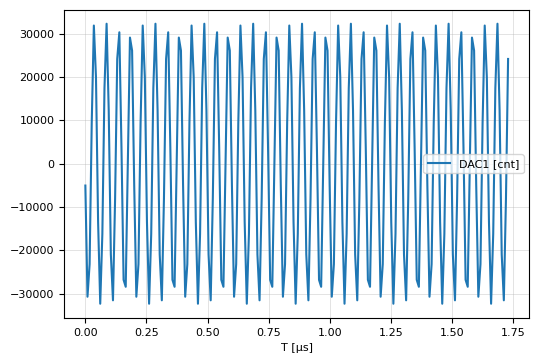

In [7]:
fs = 480 * 23 / 24 / 4  # MHz
t = np.arange(len(dac_dat)) / fs  # µs

df = pd.DataFrame({
    'T [µs]': np.arange(len(dac_dat)) / fs,
    'DAC1 [cnt]': dac_dat})
df[:200].plot(x='T [µs]');

Calculate power spectrum:

Peak frequency: 19.990 MHz
Peak magnitude: -0.099 dBFS


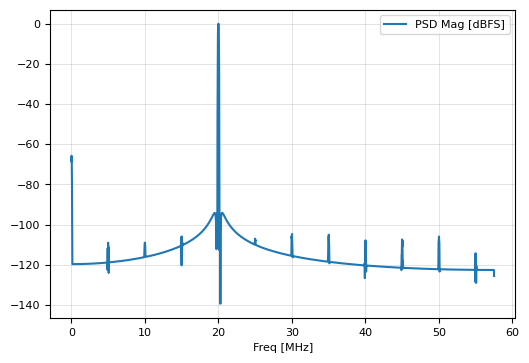

In [8]:
fs = 480 * 23 / 24 / 4  # MHz
fullscale = 1 << (16 - 1)  # signed 16 bit format, AD9781
fsdb = 20 * np.log10(fullscale / np.sqrt(2))
f, psd = signal.periodogram(
    df['DAC1 [cnt]'], fs, 'flattop', scaling='spectrum')
psd_dbfs = 10 * np.log10(psd) - fsdb
df_psd = pd.DataFrame(
    {'Freq [MHz]': f, 'PSD Mag [dBFS]': psd_dbfs})
df_psd.plot(x='Freq [MHz]');
print(f'Peak frequency: {f[np.argmax(psd)]:.3f} MHz')
print(f'Peak magnitude: {psd_dbfs[np.argmax(psd)]:.3f} dBFS')

## Check DAC waveform on the oscilloscope

Connect DAC Q1 output to the oscilloscope, expect waveforms like:

![scope waveform](uspas_llrf_dac_scope.png)

## Check DAC frequency response on spectrum analyzer

Connect DAC output to the spectrum analyzer, expect spectrum like:

![dac spectrum zoom](uspas_llrf_dac_spectrum2.png)
![dac spectrum full](uspas_llrf_dac_spectrum.png)

Compare the measured spectrum with the specified transferfunction in Figure 65 on page 29 in [AD9781 datasheet](https://www.analog.com/media/en/technical-documentation/data-sheets/ad9780_9781_9783.pdf), use the NORMAL curve. Does the DAC function as expected in terms of harmonic distortion?


## Change DAC output frequency

In open loop operation, the DAC output in the LLRF firmware is generated by up-converting the open-loop setpoint using a digital LO DDS module, which we have simulated in the `DDS` lab. A 32-bit register named `USPAS:LLRF:reg_dds_phase_step` is available through the EPICS IOC, which has a default value of 746950834, because it is a concatenated value of `{phase_step_h, phase_step_l}`, or `(182361 << 12) | 178`.

Example of reading it back using `caget`:
```bash
$ caget USPAS:LLRF:reg_dds_phase_step_RBV
USPAS:LLRF:reg_dds_phase_step_RBV 746950834
```

Use the `caput` command in terminal to change that register to a value, so that the DAC output signal can be changed from 20.00 MHz to 20.05 MHz
```bash
$ caput USPAS:LLRF:reg_dds_phase_step <your value>
```

Confirm the signal on the spectrum analyzer.

In [9]:
caget('USPAS:LLRF:reg_dds_phase_step_RBV')

746950834